### 貝葉斯優化實例

選擇保險數據集，來進行分類任務預測，基於貝葉斯和隨機優化方法進行對比分析

In [1]:
import pandas as pd
import numpy as np
import random
from tqdm import tqdm
import csv

# 繪圖
import matplotlib.pyplot as plt
import seaborn as sns
# 繪圖中有中文才需要這兩行指令
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 
plt.rcParams['axes.unicode_minus'] = False

# 建模
import lightgbm as lgb

# 貝葉斯調整參數
from hyperopt import hp
from hyperopt.pyll.stochastic import sample
from hyperopt import tpe
from hyperopt import Trials
from hyperopt import fmin
from hyperopt import STATUS_OK

In [2]:
data = pd.read_csv('data/caravan-insurance-challenge.csv')
data.head(10)

,ORIGIN,MOSTYPE,MAANTHUI,MGEMOMV,MGEMLEEF,MOSHOOFD,MGODRK,MGODPR,MGODOV,MGODGE,...,APERSONG,AGEZONG,AWAOREG,ABRAND,AZEILPL,APLEZIER,AFIETS,AINBOED,ABYSTAND,CARAVAN
0,train,33,1,3,2,8,0,5,1,3,...,0,0,0,1,0,0,0,0,0,0
1,train,37,1,2,2,8,1,4,1,4,...,0,0,0,1,0,0,0,0,0,0
2,train,37,1,2,2,8,0,4,2,4,...,0,0,0,1,0,0,0,0,0,0
3,train,9,1,3,3,3,2,3,2,4,...,0,0,0,1,0,0,0,0,0,0
4,train,40,1,4,2,10,1,4,1,4,...,0,0,0,1,0,0,0,0,0,0
5,train,23,1,2,1,5,0,5,0,5,...,0,0,0,0,0,0,0,0,0,0
6,train,39,2,3,2,9,2,2,0,5,...,0,0,0,0,0,0,0,0,0,0
7,train,33,1,2,3,8,0,7,0,2,...,0,0,0,0,0,0,0,0,0,0
8,train,33,1,2,4,8,0,1,3,6,...,0,0,0,0,0,0,0,0,0,0
9,train,11,2,3,3,3,3,5,0,2,...,0,0,0,1,0,0,0,0,0,0


In [3]:
train = data.loc[data['ORIGIN'] == 'train']
test = data.loc[data['ORIGIN'] == 'test']

In [4]:
# Extract the labels and format properly
train_labels = np.array(train['CARAVAN'])
test_labels = np.array(test['CARAVAN'])

In [5]:
# Drop the unneeded columns
train = train.drop(['ORIGIN' , 'CARAVAN'] , axis = 1)
test = test.drop(['ORIGIN' , 'CARAVAN'] , axis = 1)

# Convert to numpy array for splitting in cross validation
features = np.array(train) # features -> training data
test_features = np.array(test)
labels = train_labels[:]

print('Train shape : {}'.format(train.shape))
print('Test shape : {}'.format(test.shape))
features

Train shape : (5822, 85)
Test shape : (4000, 85)


array([[33,  1,  3, ...,  0,  0,  0],
       [37,  1,  2, ...,  0,  0,  0],
       [37,  1,  2, ...,  0,  0,  0],
       ...,
       [33,  1,  3, ...,  0,  0,  0],
       [34,  1,  3, ...,  0,  0,  0],
       [33,  1,  3, ...,  0,  0,  0]], dtype=int64)

### 標簽的分布

Text(0.5,1,'Number of Labels')

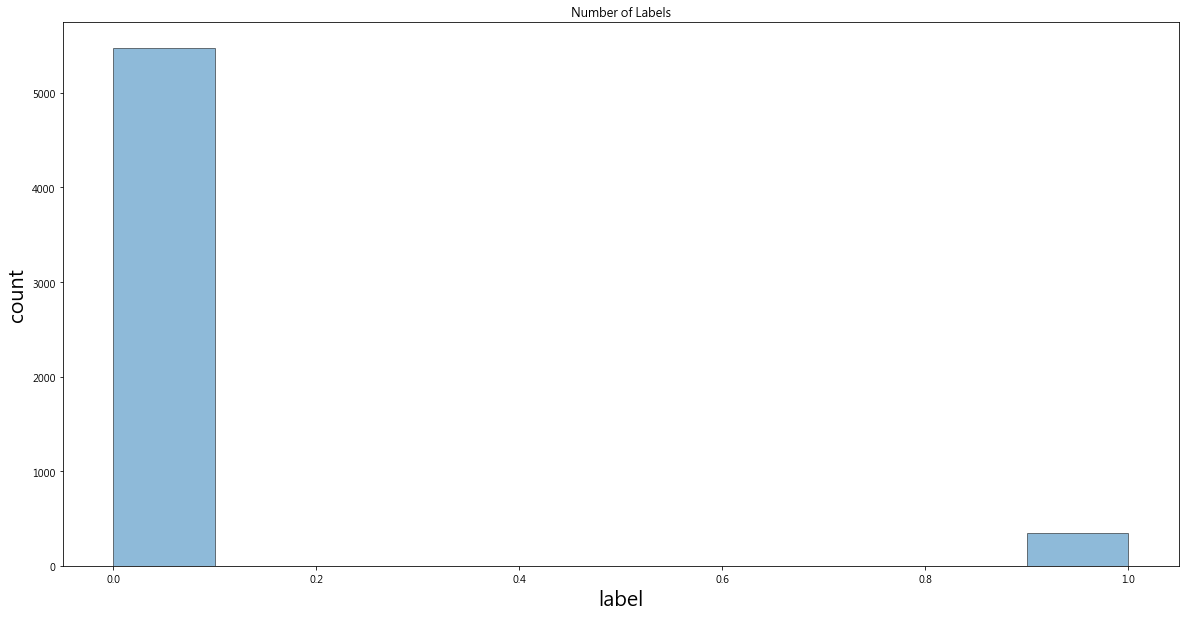

In [6]:
fig , ax = plt.subplots(1 , 1 , figsize = (20 , 10))
ax.hist(labels , alpha = 0.5 , edgecolor = 'black')
ax.set_xlabel('label' , fontsize = 20)  
ax.set_ylabel('count' , fontsize = 20)  
ax.set_title('Number of Labels')

樣本是不平衡數據，這裡先選擇基於ROC曲線計算的AUC Score來進行評估，接下來目標就是使得其AUC Score的值越大越好

### GBDT模型

使用LightGBM包來進行建模

In [7]:
# 使用LightGBM預設參數進行建模
model = lgb.LGBMClassifier()
model.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': True,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

## Random Search 

設置參數取值範圍，其中有些參數設置成了對數分布，比如學習率，因為這類參數都是要累乘才能發揮效果的，一般經驗都是寫成log分布形式

In [8]:
# Hyperparameter grid
param_grid = {'class_weight' : [None , 'balanced'],
              'boosting_type' : ['gbdt' , 'goss'],
              'num_leaves' : list(range(30 , 150)),
              'learning_rate' : list(np.logspace(np.log(0.005) , np.log(0.2) , base = np.exp(1) , num = 1000)),
              'subsample_for_bin' : list(range(20000 , 300000 , 20000)),
              'min_child_samples' : list(range(20 , 500 , 5)),
              'reg_alpha' : list(np.linspace(0 , 1)),
              'reg_lambda' : list(np.linspace(0 , 1)),
              'colsample_bytree' : list(np.linspace(0.6 , 1 , 10))}

# 把subsample_dist獨立出來的原因是，因為boosting_type若是'goss'的話，那subsample一定要是1
# 另外2種則不受限
subsample_dist = list(np.linspace(0.5 , 1 , 100))

[對數分布的解釋可以看一下這個](https://www.quora.com/Why-does-one-sample-the-log-space-when-searching-for-good-Hyper-Parameters-for-Machine-Learning) 

C:\Users\hong guo peng\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,1,'Distribution of Learning Rate')

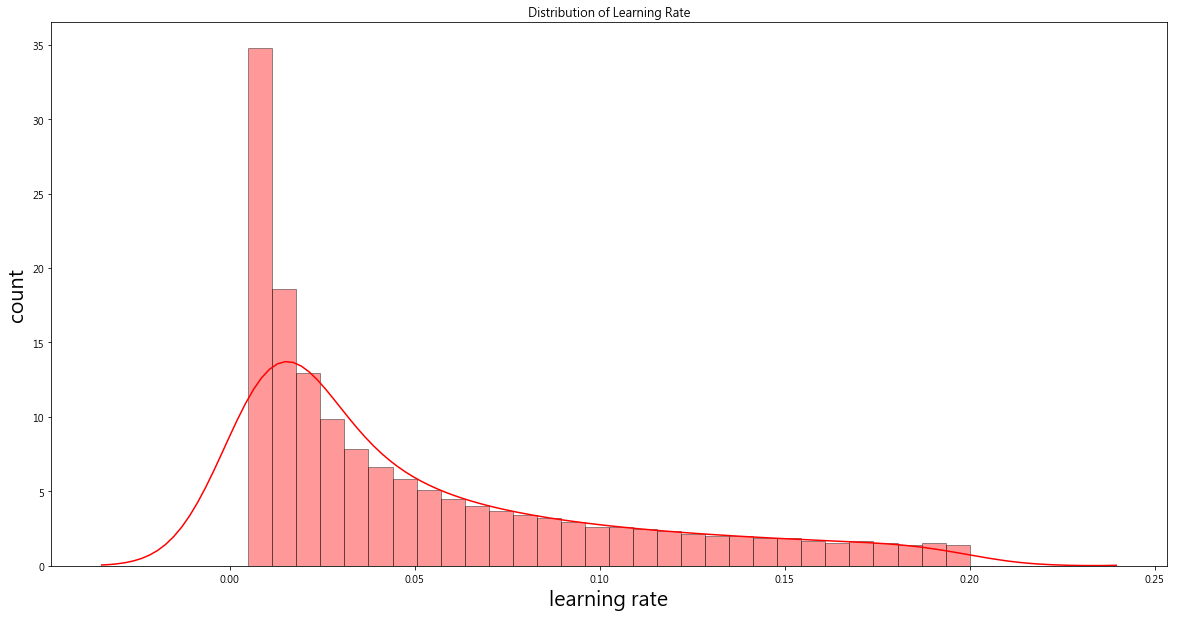

In [9]:
fig , ax = plt.subplots(1 , 1 , figsize = (20 , 10))
sns.distplot(param_grid['learning_rate'] , color = 'red' , bins = 30 , ax = ax , hist_kws = {'edgecolor' : 'k'})
ax.set_xlabel('learning rate' , fontsize = 20)  
ax.set_ylabel('count' , fontsize = 20)  
ax.set_title('Distribution of Learning Rate')

葉子數目為均勻分布

C:\Users\hong guo peng\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,1,'Distribution of Leaves')

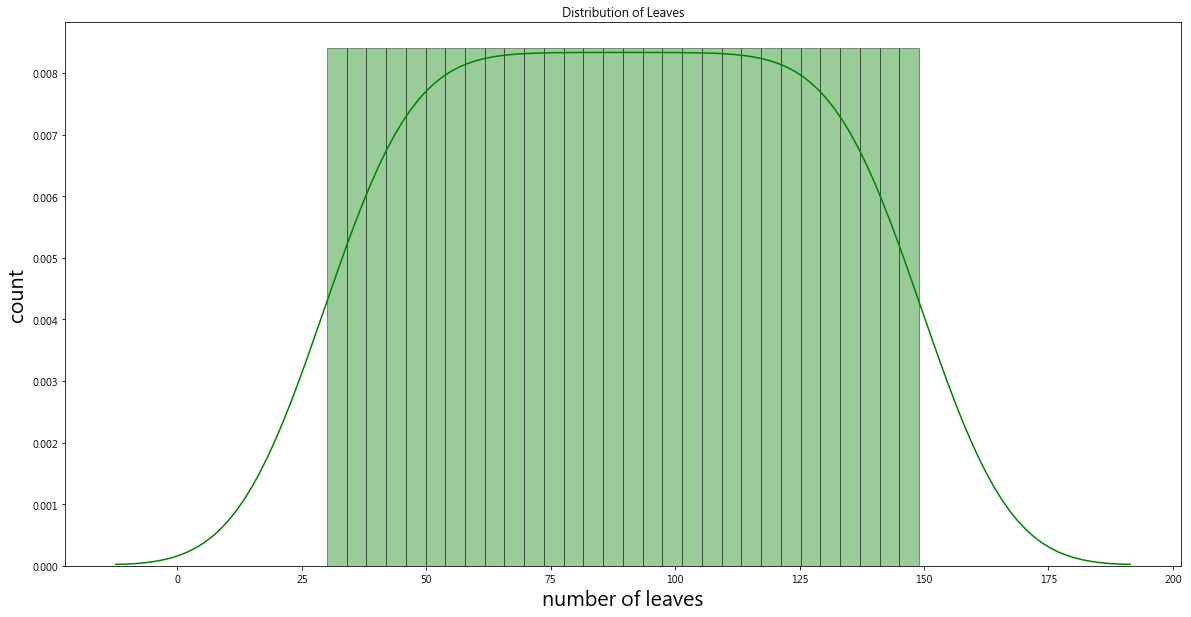

In [10]:
fig , ax = plt.subplots(1 , 1 , figsize = (20 , 10))
sns.distplot(param_grid['num_leaves'] , color = 'green' , bins = 30 ,  ax = ax , hist_kws = {'edgecolor' : 'k'})
ax.set_xlabel('number of leaves' , fontsize = 20)  
ax.set_ylabel('count' , fontsize = 20)  
ax.set_title('Distribution of Leaves')

### 在參數空間採樣

In [11]:
# 隨機取樣參數
params = {}
for key in param_grid.keys():
    params[key] = random.sample(param_grid[key] , 1)[0]
params    

{'class_weight': None,
 'boosting_type': 'gbdt',
 'num_leaves': 78,
 'learning_rate': 0.016298302492071925,
 'subsample_for_bin': 240000,
 'min_child_samples': 385,
 'reg_alpha': 0.32653061224489793,
 'reg_lambda': 0.12244897959183673,
 'colsample_bytree': 0.6888888888888889}

### 交叉驗證LightGBM

In [12]:
# 創造交叉驗店驗證的dataset
train_set = lgb.Dataset(features , label = labels) 

# 參數受到限制 => boosting_type若是'goss'的話，那subsample一定要是1    
if params['boosting_type'] != 'goss':
    params['subsample'] = random.sample(subsample_dist , 1)[0]  
else :
    params['subsample'] = 1.0

r = lgb.cv(params , 
           train_set , 
           num_boost_round = 10000 , 
           nfold = 10 , 
           metrics = 'auc',  # 以Auc為評分指標
           early_stopping_rounds = 100 , # early_stopping_rounds = 100：如果再連續迭代100次還是沒進步，那就停止迭代
           verbose_eval = False , 
           seed = 50)

# 看一下結果
r_best = np.max(r['auc-mean'])
n_estimators = len(r['auc-mean'])
print('在第{}次迭代發現最高的Auc Score : {:.3f}'.format(n_estimators , r_best))

在第115次迭代發現最高的Auc Score : 0.762


### Objective Function

用AUC指標當做我們的目標

In [13]:
def random_objective(params , iteration , n_folds = 10):
    
    # 參數受到限制 => boosting_type若是'goss'的話，那subsample一定要是1
    if params['boosting_type'] != 'goss':
        params['subsample'] = random.sample(subsample_dist , 1)[0]  
    else :
        params['subsample'] = 1.0  
      
    cv_results = lgb.cv(params , 
                        train_set , 
                        num_boost_round = 10000 , 
                        nfold = n_folds , 
                        metrics = 'auc',  # 以Auc為評分指標
                        early_stopping_rounds = 100 , # early_stopping_rounds = 100：如果再連續迭代100次還是沒進步，那就停止迭代
                        verbose_eval = False , 
                        seed = 50)
 
    best_score = np.max(cv_results['auc-mean'])
    loss = 1 - best_score
    
    n_estimators = len(cv_results['auc-mean'])

    return [loss , params , iteration , n_estimators]

### 開始執行隨機調整參數

In [14]:
# 將迭代過程存到DataFrame，方便比較
random_results = pd.DataFrame(columns = ['loss' , 'params' , 'iteration' , 'estimators'],
                              index = list(range(0 , 1000)))

random.seed(50)
for i in tqdm(range(0 , 1000)):
    
    # 隨機取樣參數
    params = {}
    for key in param_grid.keys():
        params[key] = random.sample(param_grid[key] , 1)[0]
        
    results_list = random_objective(params , i , 10)
    
    # 將迭代過程存到DataFrame
    random_results.iloc[i , :] = results_list 

100%|██████████| 1000/1000 [29:56<00:00,  2.19s/it]


In [15]:
# 將迭代過程以'loss'由小到大排列
random_results = random_results.sort_values('loss' , ascending = True)
random_results = random_results.reset_index(drop = True)

# 將所有結果存檔    
random_results.to_csv('random_results.csv')   
random_results.head()

,loss,params,iteration,estimators
0,0.233515,"{'class_weight': None, 'boosting_type': 'gbdt'...",544,102
1,0.233518,"{'class_weight': 'balanced', 'boosting_type': ...",63,59
2,0.233601,"{'class_weight': None, 'boosting_type': 'gbdt'...",925,41
3,0.233773,"{'class_weight': None, 'boosting_type': 'gbdt'...",9,365
4,0.234446,"{'class_weight': 'balanced', 'boosting_type': ...",677,331


### 貝葉斯優化
1. Domain space
2. Objective function
3. Hyperparameter optimization algorithm
4. History of results

## Domain Space

C:\Users\hong guo peng\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,1,'Distribution of Learning Rate')

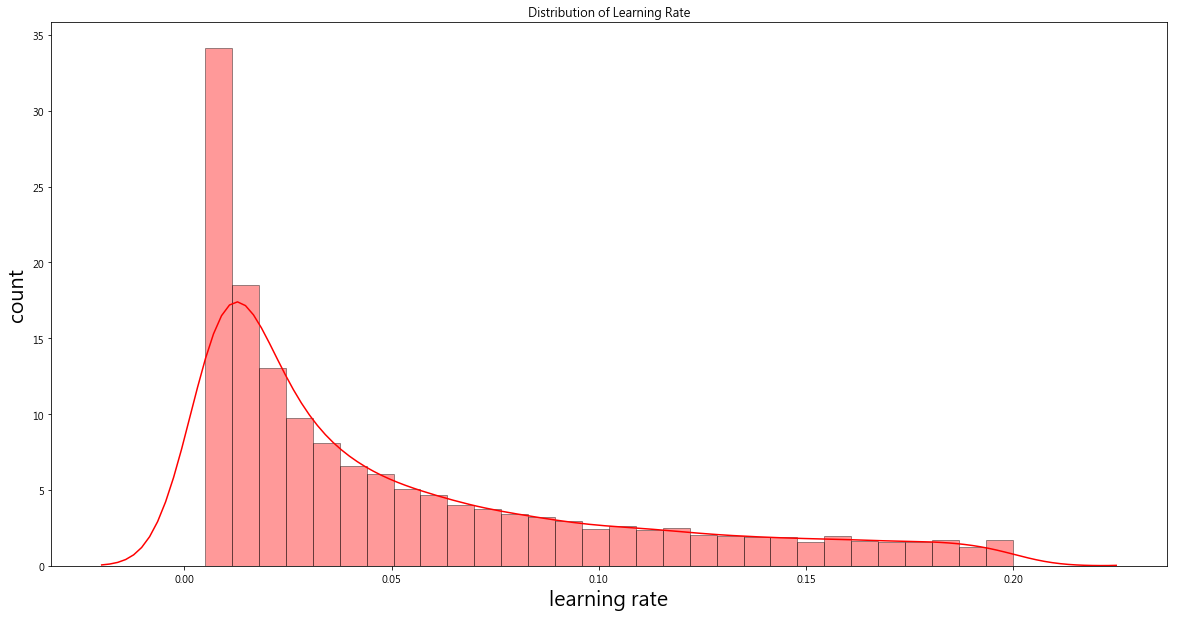

In [16]:
learning_rate = {'learning_rate' : hp.loguniform('learning_rate' , np.log(0.005) , np.log(0.2))}

learning_rate_dist = []
for _ in range(0 , 10000):
    learning_rate_dist.append(sample(learning_rate)['learning_rate'])

fig , ax = plt.subplots(1 , 1 , figsize = (20 , 10))
sns.distplot(learning_rate_dist , color = 'red' , bins = 30 ,  ax = ax , hist_kws = {'edgecolor' : 'k'})
ax.set_xlabel('learning rate' , fontsize = 20)  
ax.set_ylabel('count' , fontsize = 20)  
ax.set_title('Distribution of Learning Rate')    

C:\Users\hong guo peng\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,1,'Distribution of Leaves')

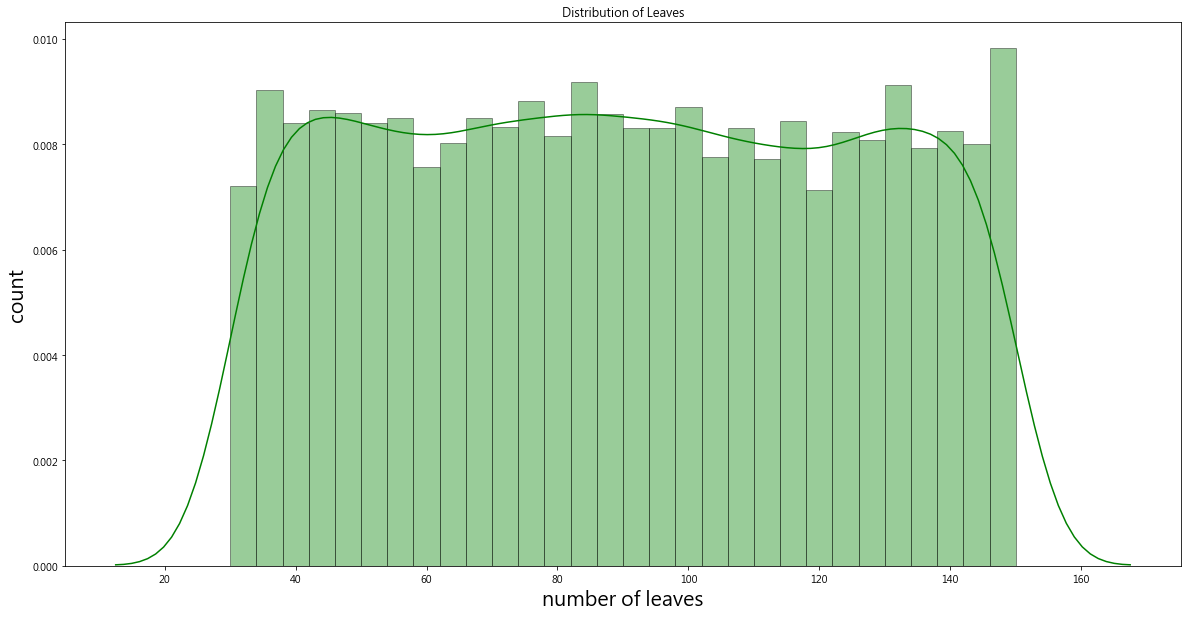

In [17]:
num_leaves = {'num_leaves' : hp.quniform('num_leaves' , 30 , 150 , 1)}

num_leaves_dist = []
for _ in range(0 , 10000):
    num_leaves_dist.append(sample(num_leaves)['num_leaves'])
    
fig , ax = plt.subplots(1 , 1 , figsize = (20 , 10))
sns.distplot(num_leaves_dist , color = 'green' , bins = 30 ,  ax = ax , hist_kws = {'edgecolor' : 'k'})
ax.set_xlabel('number of leaves' , fontsize = 20)  
ax.set_ylabel('count' , fontsize = 20)  
ax.set_title('Distribution of Leaves')

### 參數分布匯總

關於各種參數分布的解釋可以參考這個： [Hyperopt文檔](https://github.com/hyperopt/hyperopt/wiki/FMin)

In [18]:
space = {'class_weight' : hp.choice('class_weight' , [None , 'balanced']) ,
         'boosting_type' : hp.choice('boosting_type' , [{'boosting_type' : 'gbdt', 'subsample' : hp.uniform('gdbt_subsample' , 0.5 , 1)}, 
                                                       {'boosting_type' : 'goss', 'subsample' : 1.0}]),
         'learning_rate' : hp.loguniform('learning_rate' , np.log(0.01) , np.log(0.2)) ,
         'num_leaves' : hp.quniform('num_leaves' , 30 , 150, 1) ,
         'subsample_for_bin' : hp.quniform('subsample_for_bin' , 20000 , 300000 , 20000),
         'min_child_samples' : hp.quniform('min_child_samples' , 20 , 500 , 5) ,
         'reg_alpha' : hp.uniform('reg_alpha' , 0.0 , 1.0) ,
         'reg_lambda' : hp.uniform('reg_lambda', 0.0 , 1.0) ,
         'colsample_bytree' : hp.uniform('colsample_by_tree' , 0.6 , 1.0)}

x = sample(space) # 在參數空間進行採樣
x['subsample'] = x['boosting_type']['subsample']
x['boosting_type'] = x['boosting_type']['boosting_type']

### 參數采樣結果看一下

In [19]:
x

{'boosting_type': 'goss',
 'class_weight': None,
 'colsample_bytree': 0.6069538126891184,
 'learning_rate': 0.08048378297403332,
 'min_child_samples': 350.0,
 'num_leaves': 47.0,
 'reg_alpha': 0.3075170649170047,
 'reg_lambda': 0.44753536506934666,
 'subsample_for_bin': 140000.0,
 'subsample': 1.0}

### Objective Function 



In [20]:
global iteration
iteration = 0
def objective(params , n_folds = 10):   
    
    global iteration
    iteration += 1
    
    params['subsample'] = params['boosting_type']['subsample'] 
    params['boosting_type'] = params['boosting_type']['boosting_type']
    
    # 保證'num_leaves', 'subsample_for_bin', 'min_child_samples'都是整數值
    for parameter_name in ['num_leaves' , 'subsample_for_bin' , 'min_child_samples']:
        params[parameter_name] = int(params[parameter_name])
        
    cv_results = lgb.cv(params , 
                        train_set , 
                        num_boost_round = 10000 , 
                        nfold = n_folds , 
                        metrics = 'auc',  # 以Auc為評分指標
                        early_stopping_rounds = 100 , # early_stopping_rounds = 100：如果再連續迭代100次還是沒進步，那就停止迭代
                        verbose_eval = False , 
                        seed = 50)
    
    # Extract the best score
    best_score = np.max(cv_results['auc-mean'])
    
    # Loss must be minimized
    loss = 1 - best_score
    
    # Boosting rounds that returned the highest cv score
    n_estimators = int(len(cv_results['auc-mean']))
    
    # Dictionary with information for evaluation
    return {'loss': loss ,
            'params': params ,
            'iteration': iteration ,
            'estimators': n_estimators , 
            'status': STATUS_OK}

### 準備貝葉斯優化

In [21]:
# optimization algorithm
tpe_algorithm = tpe.suggest

# Keep track of results
bayes_trials = Trials()

best = fmin(fn = objective ,
            space = space ,
            algo = tpe.suggest, 
            max_evals = 1000 , 
            trials = bayes_trials , 
            rstate = np.random.RandomState(50))

100%|██████████| 1000/1000 [39:23<00:00,  2.95s/it, best loss: 0.23142807831041512]


In [22]:
# 將迭代過程以'loss'由小到大排列
bayes_trials_results_temp = sorted(bayes_trials.results , key = lambda x : x['loss'])

# 將迭代過程存到DataFrame
bayes_trials_results_ = pd.DataFrame(columns = ['loss' , 'params' , 'iteration' , 'estimators'],
                                     index = list(range(0 , 1000)))
for i in range(0 , 1000):
    bayes_trials_results_.iloc[i , :] = bayes_trials_results_temp[i]
    
# 將所有結果存檔    
bayes_trials_results_.to_csv('bayes_trials_results.csv') 
bayes_trials_results_.head()

,loss,params,iteration,estimators
0,0.231428,"{'boosting_type': 'gbdt', 'class_weight': 'bal...",763,115
1,0.231451,"{'boosting_type': 'gbdt', 'class_weight': 'bal...",411,171
2,0.232005,"{'boosting_type': 'gbdt', 'class_weight': None...",5,182
3,0.232009,"{'boosting_type': 'gbdt', 'class_weight': 'bal...",787,127
4,0.232083,"{'boosting_type': 'gbdt', 'class_weight': 'bal...",800,153


### 調參過程可視化展示

In [23]:
# 讀取存檔
random_results = pd.read_csv('random_results.csv')
bayes_trials_results = pd.read_csv('bayes_trials_results.csv')

In [24]:
# eval() => str轉換成dict

# 將random_results中的'params'提取出來
random_params = pd.DataFrame(columns = list(eval(random_results['params'][0]).keys()),
                             index = list(range(0 , len(random_results))))

for i , params in enumerate(random_results['params']):
    random_params.iloc[i , :] = list(eval(params).values())
    
random_params['loss'] = random_results['loss']
random_params['iteration'] = random_results['iteration']


# 將bayes_trials_results中的'params'提取出來
bayes_params = pd.DataFrame(columns = list(eval(bayes_trials_results['params'][0]).keys()),
                            index = list(range(0 , len(bayes_trials_results))))

for i , params in enumerate(bayes_trials_results['params']):
    bayes_params.iloc[i, :] = list(eval(params).values())
    
bayes_params['loss'] = bayes_trials_results['loss']
bayes_params['iteration'] = bayes_trials_results['iteration']

In [25]:
random_params.head(10)

,class_weight,boosting_type,num_leaves,learning_rate,subsample_for_bin,min_child_samples,reg_alpha,reg_lambda,colsample_bytree,subsample,loss,iteration
0,None,gbdt,50,0.0336094,80000,235,0.836735,0.0612245,0.688889,0.818182,0.233515,544
1,balanced,gbdt,99,0.0460015,140000,275,0.142857,0.938776,0.644444,0.752525,0.233518,63
2,None,gbdt,38,0.0791608,20000,265,0.102041,0.612245,0.6,0.59596,0.233601,925
3,None,gbdt,137,0.00838461,100000,260,0.306122,0.428571,0.6,0.90404,0.233773,9
4,balanced,gbdt,102,0.0102348,280000,220,0.632653,0.22449,0.644444,0.681818,0.234446,677
5,None,gbdt,30,0.0751725,160000,270,0.408163,0.326531,0.688889,0.909091,0.234481,317
6,None,gbdt,110,0.0131077,80000,270,0.387755,0.0204082,0.6,0.60101,0.234741,616
7,balanced,gbdt,72,0.0126325,60000,175,0.673469,0.44898,0.6,1,0.234847,36
8,None,gbdt,68,0.0454947,160000,250,0,0.959184,0.733333,0.555556,0.234958,645
9,None,gbdt,57,0.0332391,100000,160,0.428571,0.285714,0.688889,0.823232,0.234993,673


In [26]:
bayes_params.head(10)

,boosting_type,class_weight,colsample_bytree,learning_rate,min_child_samples,num_leaves,reg_alpha,reg_lambda,subsample_for_bin,subsample,loss,iteration
0,gbdt,balanced,0.63418,0.0247964,260,64,0.235965,0.55003,260000,0.578584,0.231428,763
1,gbdt,balanced,0.62283,0.0216747,255,108,0.670253,0.0764615,260000,0.501821,0.231451,411
2,gbdt,None,0.620649,0.0179345,260,30,0.209298,0.894689,20000,0.873149,0.232005,5
3,gbdt,balanced,0.613014,0.0216843,265,76,0.151056,0.91471,260000,0.582233,0.232009,787
4,gbdt,balanced,0.627018,0.0205433,260,65,0.138801,0.998975,280000,0.51165,0.232083,800
5,gbdt,balanced,0.637935,0.0247936,255,66,0.132321,0.33569,300000,0.781124,0.232123,118
6,gbdt,balanced,0.639713,0.0202883,260,123,0.495654,0.153976,260000,0.622962,0.232160,581
7,gbdt,None,0.633273,0.0242948,255,80,0.266393,0.880365,60000,0.854703,0.232187,269
8,gbdt,balanced,0.626689,0.0194071,265,78,0.172338,0.982454,280000,0.614036,0.232225,791
9,gbdt,balanced,0.628601,0.0197745,270,86,0.841509,0.39663,200000,0.639267,0.232243,483


### 觀察Boosting Type取樣的過程

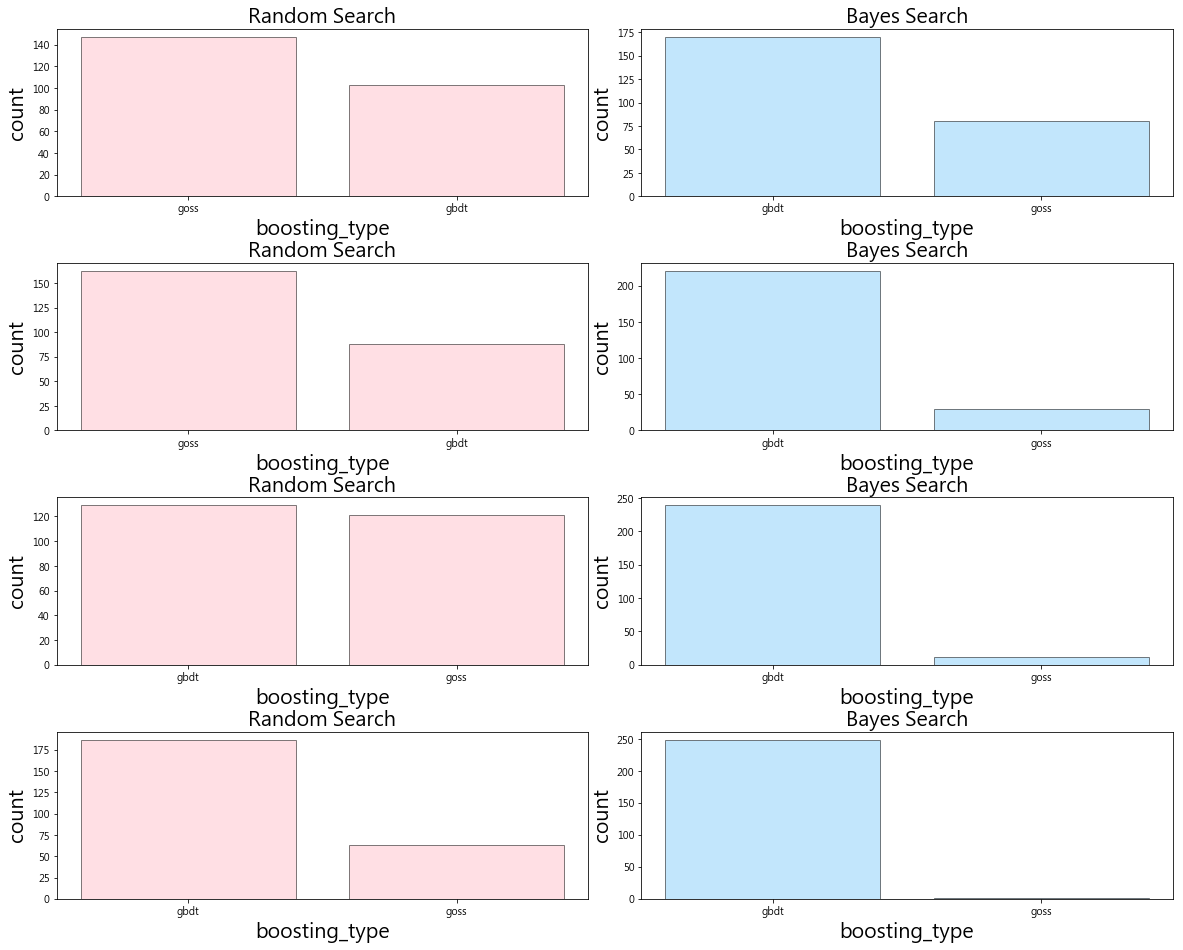

In [27]:
fig, ax = plt.subplots(4 , 2 , figsize = (20 , 16))
plt.subplots_adjust(wspace = 0.1 , hspace = 0.4)
point = [[750 , 1000] , [500 , 750] , [250 , 500] , [0 , 250]]

for i in range(0 , 4):
    start = point[i][0]
    end = point[i][1]
    
    random = random_params['boosting_type'][start:end].value_counts()
    bayes = bayes_params['boosting_type'][start:end].value_counts()
    
    ax[i , 0].bar(random.index , random.values , alpha = 0.5 , facecolor = 'pink' , edgecolor = 'black')
    ax[i , 0].set_xlabel('boosting_type' , fontsize = 20)
    ax[i , 0].set_ylabel('count' , fontsize = 20)
    ax[i , 0].set_title('Random Search' , fontsize = 20)
    
    ax[i , 1].bar(bayes.index , bayes.values , alpha = 0.5 , facecolor = 'lightskyblue' , edgecolor = 'black')
    ax[i , 1].set_xlabel('boosting_type' , fontsize = 20)
    ax[i , 1].set_ylabel('count' , fontsize = 20)
    ax[i , 1].set_title('Bayes Search' , fontsize = 20)

可以發現Bayes Search中的boosting Type隨著loss越小，會取樣越來越集中在gdpt，但Random Search卻沒什麼變化

觀察個別參數率取樣的過程(learning_rate、num_leaves、subsample_for_bin、min_child_samples)<br>
可以發現下面的所有參數在Bayes Search中都隨著loss越小，取樣會越來越集中在一個地方

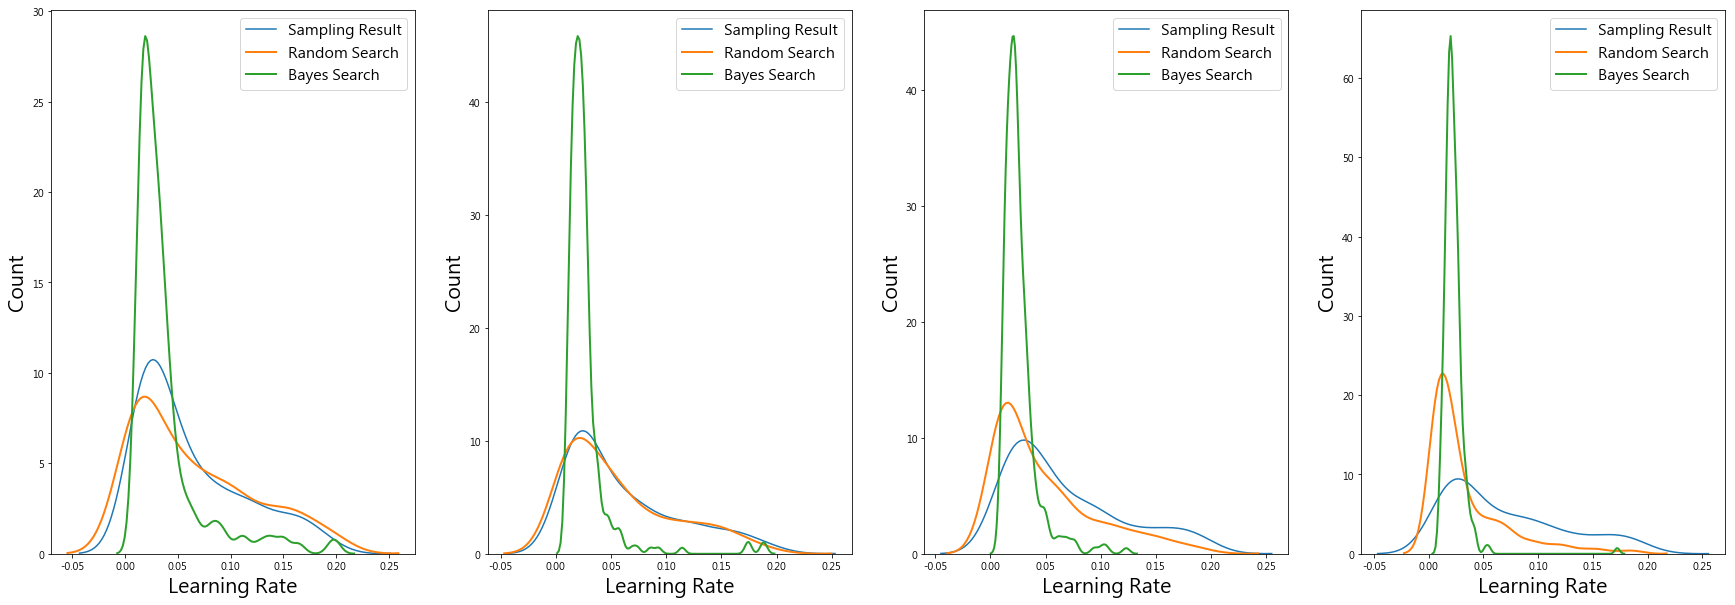

In [28]:
fig , ax = plt.subplots(1 , 4 , figsize = (30 , 10))
point = [[750 , 1000] , [500 , 750] , [250 , 500] , [0 , 250]]
for i in range(0 , 4):
    start = point[i][0]
    end = point[i][1]
    sns.kdeplot([sample(space['learning_rate']) for _ in range(0 , 250)] , label = 'Sampling Result' , ax = ax[i])
    sns.kdeplot(random_params['learning_rate'][start:end] , label = 'Random Search' , linewidth = 2 , ax = ax[i])
    sns.kdeplot(bayes_params['learning_rate'][start:end] , label = 'Bayes Search' , linewidth = 2 , ax = ax[i])
    ax[i].legend(loc = 'upper right' , fontsize = 15)
    ax[i].set_xlabel('Learning Rate' , fontsize = 20)
    ax[i].set_ylabel('Count' , fontsize = 20)

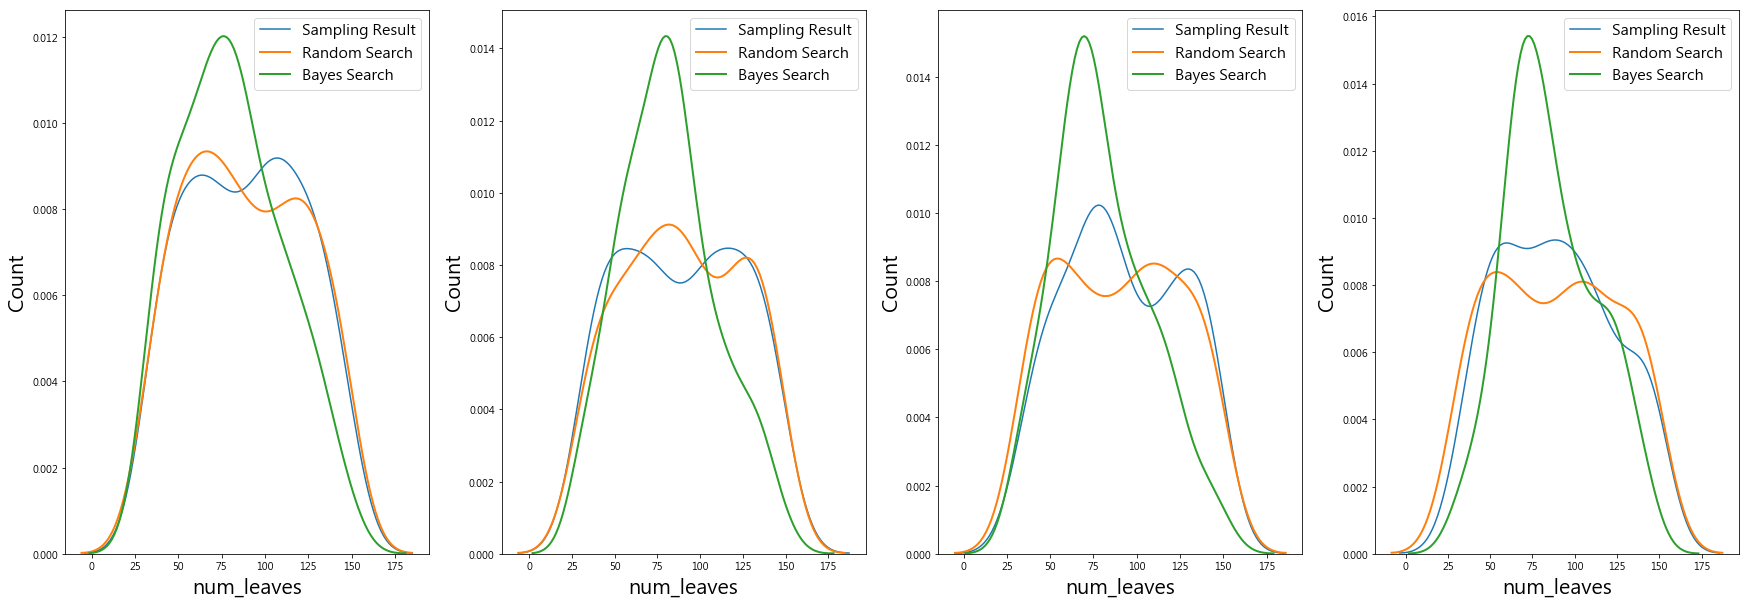

In [29]:
fig , ax = plt.subplots(1 , 4 , figsize = (30 , 10))
point = [[750 , 1000] , [500 , 750] , [250 , 500] , [0 , 250]]
for i in range(0 , 4):
    start = point[i][0]
    end = point[i][1]
    sns.kdeplot([sample(space['num_leaves']) for _ in range(0 , 250)] , label = 'Sampling Result' , ax = ax[i])
    sns.kdeplot(random_params['num_leaves'][start:end] , label = 'Random Search' , linewidth = 2 , ax = ax[i])
    sns.kdeplot(bayes_params['num_leaves'][start:end] , label = 'Bayes Search' , linewidth = 2 , ax = ax[i])
    ax[i].legend(loc = 'upper right' , fontsize = 15)
    ax[i].set_xlabel('num_leaves' , fontsize = 20)
    ax[i].set_ylabel('Count' , fontsize = 20)

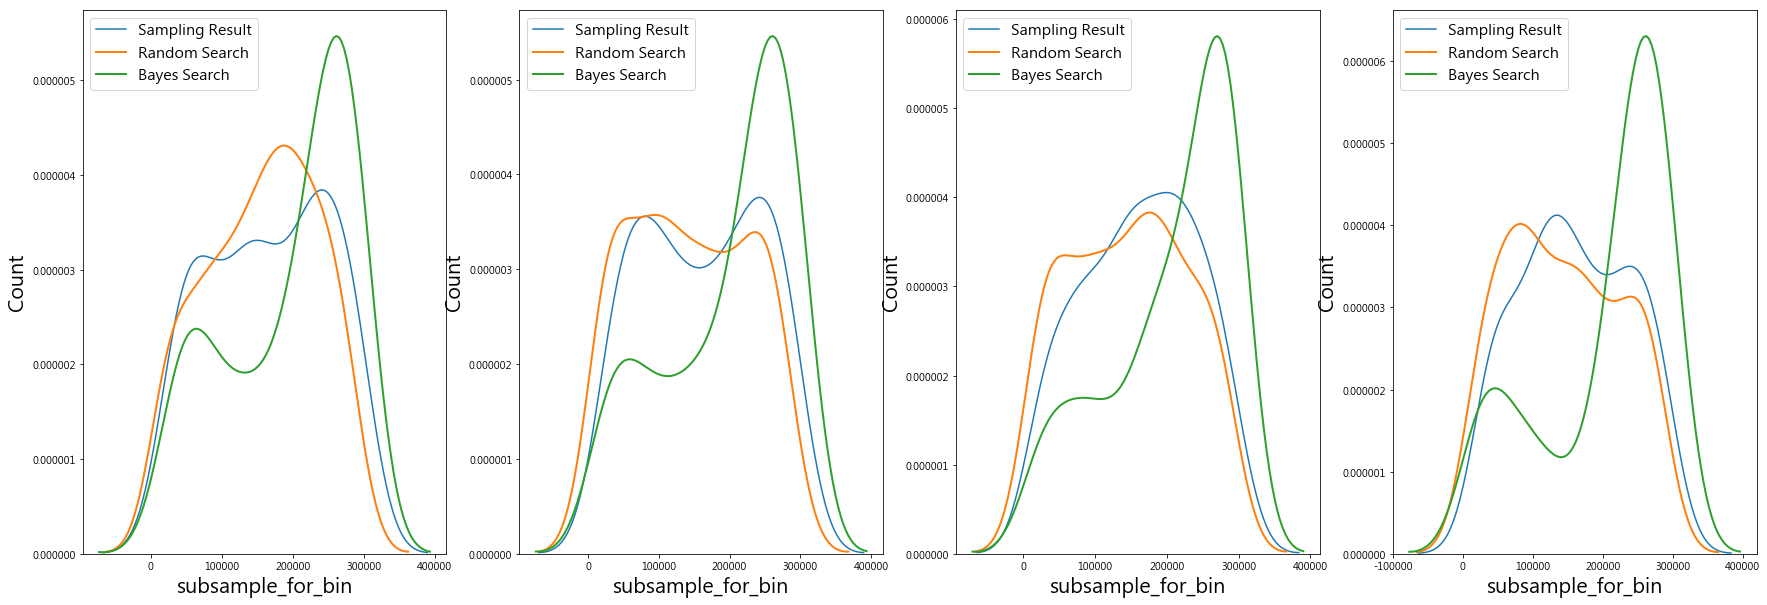

In [30]:
fig , ax = plt.subplots(1 , 4 , figsize = (30 , 10))
point = [[750 , 1000] , [500 , 750] , [250 , 500] , [0 , 250]]
for i in range(0 , 4):
    start = point[i][0]
    end = point[i][1]
    sns.kdeplot([sample(space['subsample_for_bin']) for _ in range(0 , 250)] , label = 'Sampling Result' , ax = ax[i])
    sns.kdeplot(random_params['subsample_for_bin'][start:end] , label = 'Random Search' , linewidth = 2 , ax = ax[i])
    sns.kdeplot(bayes_params['subsample_for_bin'][start:end] , label = 'Bayes Search' , linewidth = 2 , ax = ax[i])
    ax[i].legend(loc = 'upper left' , fontsize = 15)
    ax[i].set_xlabel('subsample_for_bin' , fontsize = 20)
    ax[i].set_ylabel('Count' , fontsize = 20)

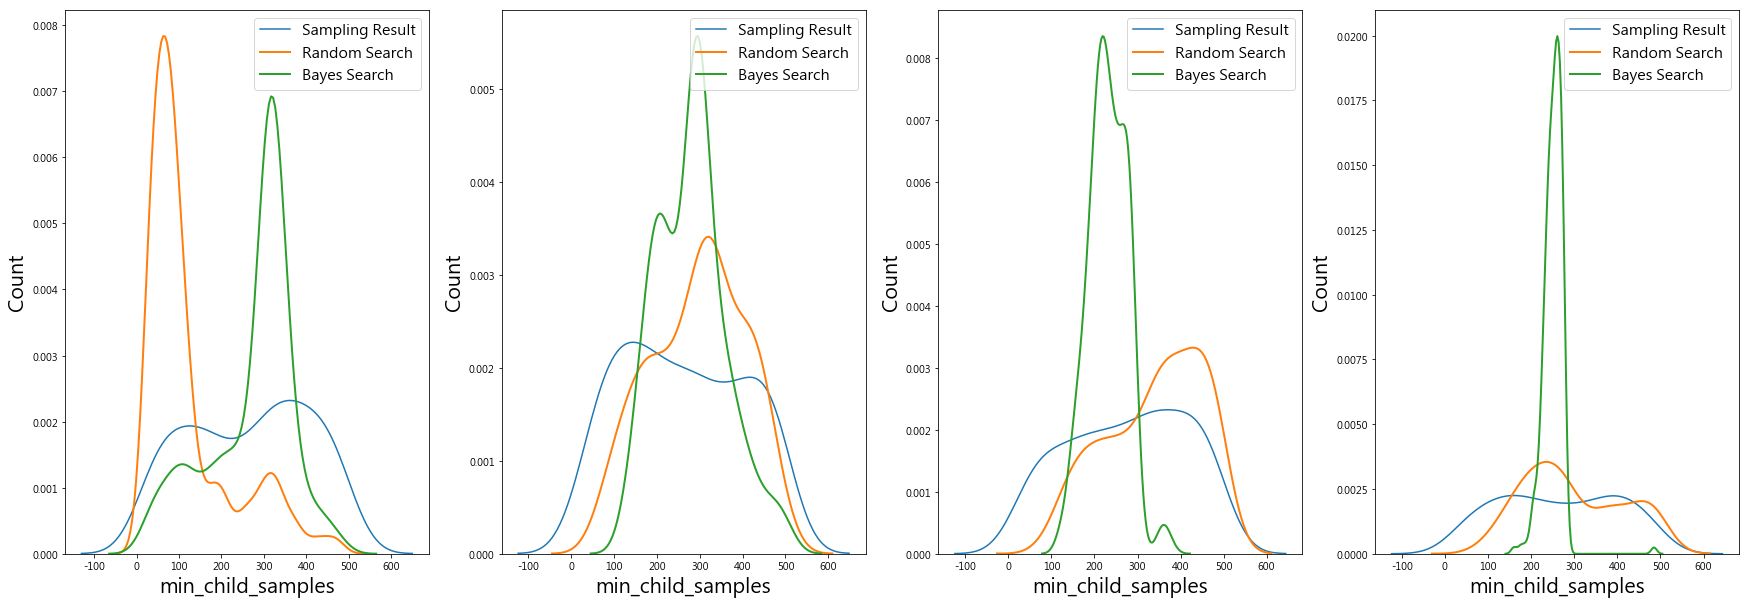

In [31]:
fig , ax = plt.subplots(1 , 4 , figsize = (30 , 10))
point = [[750 , 1000] , [500 , 750] , [250 , 500] , [0 , 250]]
for i in range(0 , 4):
    start = point[i][0]
    end = point[i][1]
    sns.kdeplot([sample(space['min_child_samples']) for _ in range(0 , 250)] , label = 'Sampling Result' , ax = ax[i])
    sns.kdeplot(random_params['min_child_samples'][start:end] , label = 'Random Search' , linewidth = 2 , ax = ax[i])
    sns.kdeplot(bayes_params['min_child_samples'][start:end] , label = 'Bayes Search' , linewidth = 2 , ax = ax[i])
    ax[i].legend(loc = 'upper right' , fontsize = 15)
    ax[i].set_xlabel('min_child_samples' , fontsize = 20)
    ax[i].set_ylabel('Count' , fontsize = 20)

### 觀察loss變化的過程
### 可以看到Bayes Search與Random Search的loss的distribution在x軸上差得越來越多

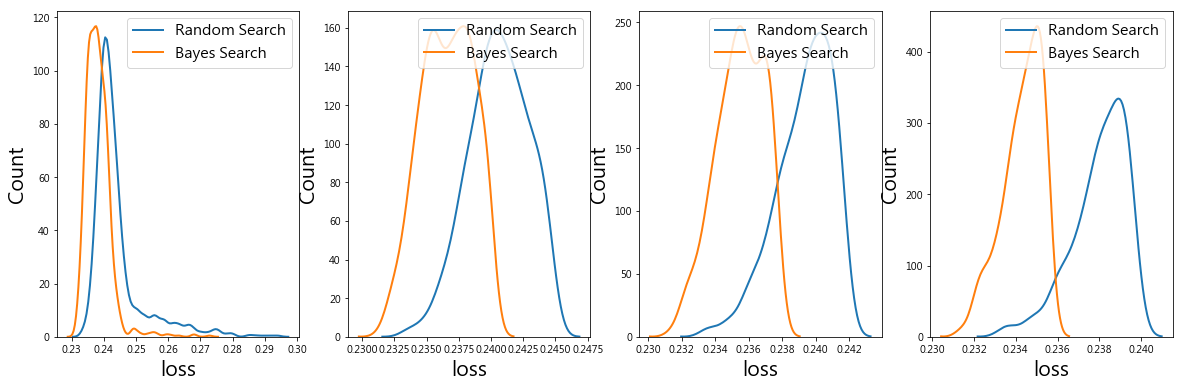

In [32]:
fig , ax = plt.subplots(1 , 4 , figsize = (20 , 6))
point = [1000 , 750 , 500 , 250]
for i in range(0 , 4):
    sns.kdeplot(random_params['loss'][:point[i]] , label = 'Random Search' , linewidth = 2 , ax = ax[i])
    sns.kdeplot(bayes_params['loss'][:point[i]] , label = 'Bayes Search' , linewidth = 2 , ax = ax[i])
    ax[i].legend(loc = 'upper right' , fontsize = 15)
    ax[i].set_xlabel('loss' , fontsize = 20)
    ax[i].set_ylabel('Count' , fontsize = 20)

### 觀察各項參數隨著每次迭代取樣的情況

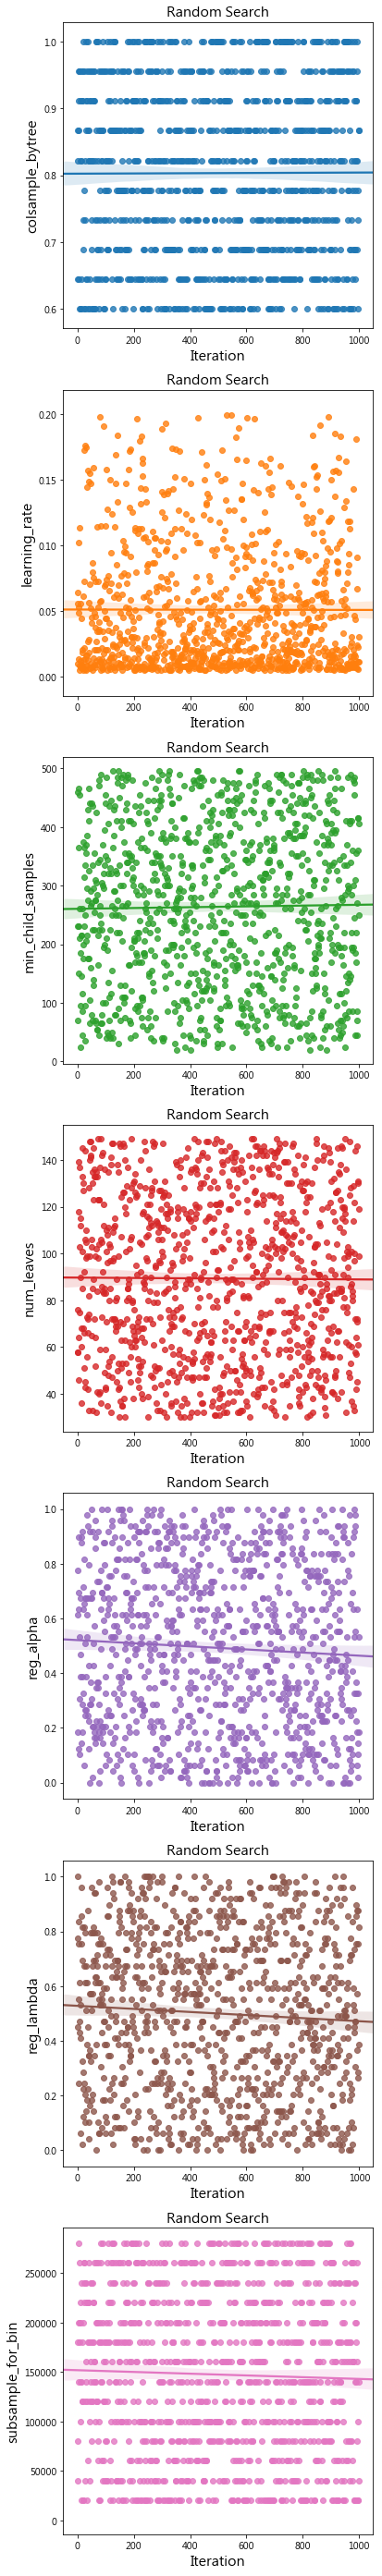

In [33]:
fig, ax = plt.subplots(7 , 1 , figsize = (6 , 50))

hyperparameter = ['colsample_bytree', 'learning_rate', 'min_child_samples', 'num_leaves' , 'reg_alpha', 'reg_lambda', 'subsample_for_bin']
for i , param in enumerate(hyperparameter):
    sns.regplot(x = 'iteration' , y = hyperparameter[i] , data = random_params , x_jitter = 0.05 , ax = ax[i])
    ax[i].set_title('Random Search' , fontsize = 15)
    ax[i].set_xlabel('Iteration' , fontsize = 15)
    ax[i].set_ylabel(param , fontsize = 15)

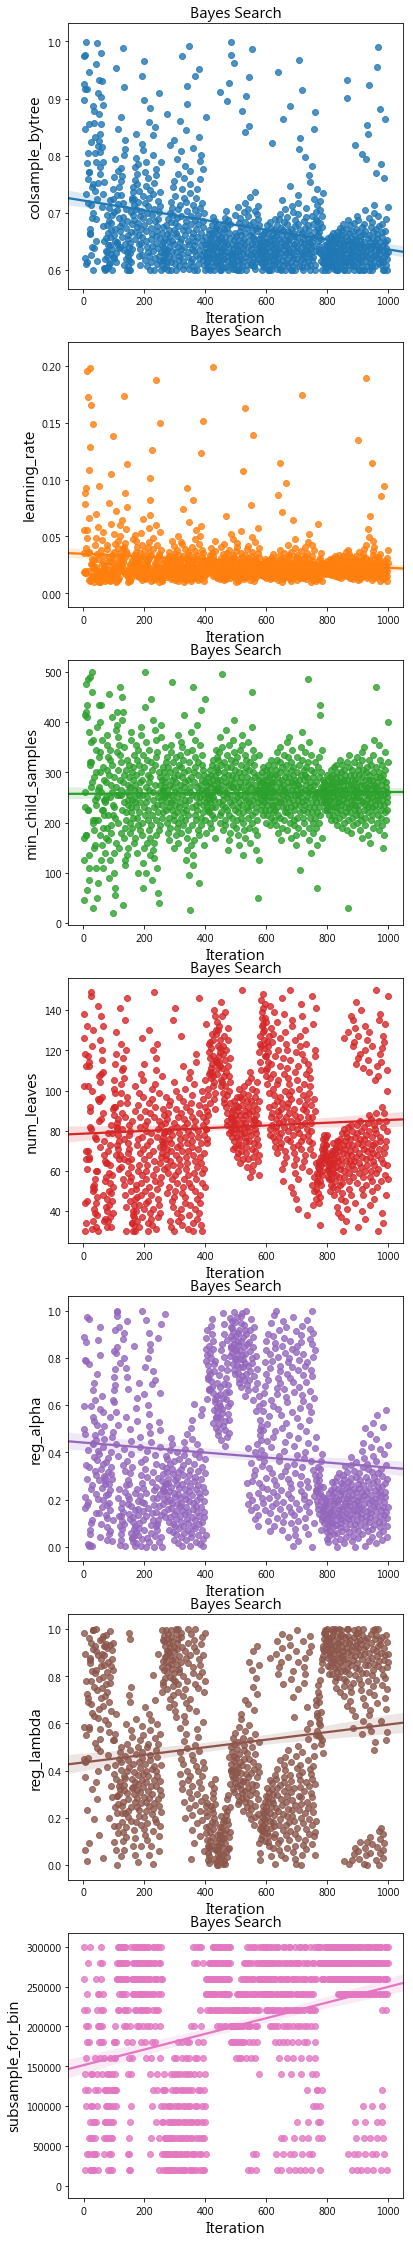

In [34]:
fig, ax = plt.subplots(7 , 1 , figsize = (6 , 40))

hyperparameter = ['colsample_bytree', 'learning_rate', 'min_child_samples', 'num_leaves' , 'reg_alpha', 'reg_lambda', 'subsample_for_bin']
for i , param in enumerate(hyperparameter):
    sns.regplot(x = 'iteration' , y = hyperparameter[i] , data = bayes_params , x_jitter = 0.05 , ax = ax[i])
    ax[i].set_title('Bayes Search' , fontsize = 15)
    ax[i].set_xlabel('Iteration' , fontsize = 15)
    ax[i].set_ylabel(param , fontsize = 15)

Bayes Search比起Random Search更有方向性與目的

### 觀察loss隨每次迭代的狀況

Text(0.5,1,'Bayes Search')

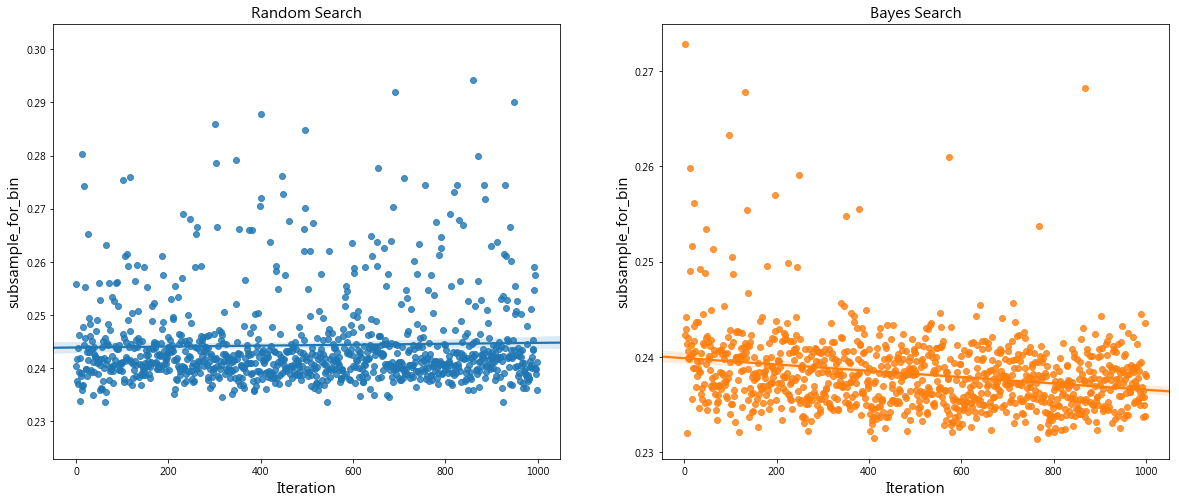

In [35]:
fig, ax = plt.subplots(1 , 2 , figsize = (20 , 8))

sns.regplot(x = 'iteration' , y = 'loss' , data = random_params , x_jitter = 0.05 , ax = ax[0])
ax[0].set_xlabel('Iteration' , fontsize = 15)
ax[0].set_ylabel(param , fontsize = 15)
ax[0].set_title('Random Search' , fontsize = 15)

sns.regplot(x = 'iteration' , y = 'loss' , data = bayes_params , x_jitter = 0.05 , ax = ax[1])
ax[1].set_xlabel('Iteration' , fontsize = 15)
ax[1].set_ylabel(param , fontsize = 15)
ax[1].set_title('Bayes Search' , fontsize = 15)

可以發現Bayes Search的loss隨著每次迭代有變少的趨勢，而Random Search並沒有發現此現象

## 存檔並繼續優化
可以參考 [pass it a trials object that already has information on previous runs](https://github.com/hyperopt/hyperopt/issues/267). 

In [36]:
# 將bayes_trials存檔，下次可拿出來繼續使用
import pickle
pickle.dump(bayes_trials , open('myfile.p' , 'wb'))
continue_bayes_trials = pickle.load(open('myfile.p' , 'rb'))

In [37]:
iteration = 1000 + 1
best = fmin(fn = objective ,
            space = space ,
            algo = tpe.suggest, 
            max_evals = len(continue_bayes_trials.trials) + 1000 , # 再迭代1000次看看loss有沒有變小 
            trials = continue_bayes_trials , 
            rstate = np.random.RandomState(50))

100%|██████████| 1000/1000 [51:04<00:00,  3.64s/it, best loss: 0.2309960653151959]  


結果略微的提高<br>
其實也可以按照貝葉斯優化給出的大致區間，再進一步做grid search也是一個不錯的想法